<a href="https://colab.research.google.com/github/Bovi-analytics/scheurwater-et-al-2021/blob/main/Peak_detection_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for the algorithm

This is a Google Colab Notebook. It has a google machine in the back which will activate the moment you click the play button from the first cell. You can run cells seperately, or all after eachother, it allows you to prototype much easier then using the PyCharm.

The notebook can be shared and editted by multiple people. If you want to work in your own version, you can make a copy of the notebook first.

#GDrive
You need to make a link with the data. This is all stored in your google drive , or in the case of this notebook a bovi-analytics folder.

First run the cell underneath, then open the link in the output and copy the code underneath. That way, the Google Drive is connected.

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


The next cell should show files that are in the folder.

In [ ]:
!ls /content/gdrive/'Shared drives'/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos

raw_data_video_k13_20190227_1108.csv
raw_data_video_k13_20190412_1108.csv
raw_data_video_k21_20190205_1108.csv
raw_data_video_k21_20190218_1108.csv
raw_data_video_k21_20190225v2_1108.csv
raw_data_video_k21_20190304_1012.csv
raw_data_video_k2_20190301_1108.csv
raw_data_video_k2_20190403_1108.csv
raw_data_video_k2_20190411_1108.csv
raw_data_video_k2_20190416_1108.csv
raw_data_video_k26_20190325_1108.csv
raw_data_video_k26_20190404_1108.csv
raw_data_video_k26_20190410_1108.csv
raw_data_video_k84_20190405__corr37sec_1108.csv
ruwe_data_video_k84_20190226v2_1108.csv
ruwe_data_video_k84_20190305_1108.csv
ruwe_data_video_k84_20190415_1108.csv


# Start the PICO algorythm

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime

## Set directories

In [ ]:
# directorie#directories waarmee je gaat werken definiëren
base_dir = '/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog'
output_dir = '/data/out/'
input_dir = '/data/in/traintest/picologs/'
video_dir= '/data/in/traintest/videos/'
output_path = base_dir + output_dir
input_path = base_dir + input_dir
video_path = base_dir + video_dir


In [ ]:
#output directory aanmaken:
if os.path.isdir ( output_path ):
    pass
else:
    os.mkdir (output_path )

In [ ]:
# oud bestand met output eerst weggooien:
for f in os.listdir(output_path):
    print('Existing file : ' + f)
    oldfile = output_path + f
    if os.path.isfile(oldfile):
        os.remove(oldfile)
        print('Removed : ' + oldfile)
    else:
        pass
        print('Did not remove : ' + oldfile)

Existing file : ylva
Did not remove : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/ylva
Existing file : processed_raw_data_pico_20190415_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190415_0708.csv
Existing file : processed_raw_data_pico_20190412_1_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_1_0708.csv
Existing file : processed_raw_data_pico_20190412_2_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_2_0708.csv
Existing file : processed_raw_data_pico_20190411_1_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190411_1_0708.csv
Existing file : processed_raw_

## Algorythm function

In [ ]:
def picoalgoritme_gain(data, gain_peakdetection = 9,col=0):
    # Data window paramters, 0,5s per sample
    start = 1
    Data = 0
    Rumination = 0
    PeakValue = 0
    PressureDetected = 0
    LowTimeCounterHold = 0

    # Peak detection parameters
    Slope_Rise = 2 * gain_peakdetection;
    Slope_Fall = gain_peakdetection;
    Actual_Rise = float(0)
    Actual_Fall = float(0)

    # Rumination detection parameters
    State = 1
    Timer_D = 0
    Timer_E = 0
    Timer_F = 0
    Pulse_High_flank = 0
    Rumination_Time = 10  # 0,5s samplerate -> 5s
    D = 10  # 0,5s samplerate -> 5s
    E = 30  # 0,5s samplerate -> 15s
    F = 10  # 0,5s samplerate -> 5s
    Pulse_detected = 0
    Pulse_detected_old = 0

    # Low time parameters
    Lowtime_counter = 0

    # Moving average filter
    MA_Filter = 0
    Baseline = 0
    Windowsize = 150
    Highest_peak = 0

    # High pressure detection parameters
    High_Pressure_level = 3500

    # Loop for pulse detection
    for i in range(1,np.size(data[:, col])):
        Actual_Rise = data[i - 8, col] - data[i - 5, col]
        Actual_Fall = data[i - 8, col] - data[i - 10, col]

        # measure highest peak
        if ((data[i, col] - Baseline) > Highest_peak and i > (Windowsize + 10)):
            Highest_peak = (data[i, col] - Baseline)

        # Calculating moving average filter
        MA_Filter = 0
        if i > Windowsize:
            for j in range(1, Windowsize):
                MA_Filter = MA_Filter + data[i - j, col]
            Baseline = int(MA_Filter / Windowsize)
            data[i, 5] = Baseline

        # High pressure level detection
        if ((data[i, col] - Baseline) > High_Pressure_level):
            data[i, 8] = 1000

        Pulse_detected = 0
        if Actual_Rise >= Slope_Rise and Actual_Fall >= Slope_Fall:
            Pulse_detected = 1

        # flank detection
        if Pulse_detected_old == 0 and Pulse_detected == 1:
            Pulse_High_flank = 1
        Pulse_detected_old = Pulse_detected
        Pulse_detected = 0
        data[i, 1] = Pulse_High_flank
        data[i, 2] = State
        data[i, 4] = LowTimeCounterHold

        if State == 1:  # Wait for minimal low time
            if Timer_D >= D:
                State = 2
                Lowtime_counter = 0
                Highest_peak = 0

            if Pulse_High_flank == 1:
                State = 1
                Timer_D = 0
                Pulse_High_flank = 0

        elif State == 2:  # Wait for first pulse
            if Pulse_High_flank == 1:
                State = 3
                Timer_E = 0;
                PulsLowTime = 0
                Pulse_High_flank = 0

        elif State == 3:  # Wait for second pulse
            if Timer_E == E:
                State = 1
                Timer_D = 0
            if Pulse_High_flank == 1:
                Timer_F = 0;
                Pulse_High_flank = 0
                if Timer_E >= Rumination_Time:
                    State = 5
                    Timer_F = 0;
                else:
                    State = 4
                    Timer_F = 0;

        elif State == 4:  # Wait for third pulse or minimal low time
            if Timer_F == F:
                State = 1
                Timer_D = 0
                # Normal wave detected
                LowTimeCounterHold = Lowtime_counter/2
                data[i, 3] = 1
                data[i, 6] = Highest_peak
                Rumination = 0
                PeakValue = Highest_peak
            if Pulse_High_flank == 1:
                State = 5
                Pulse_High_flank = 0

        elif State == 5:  # Wait for third pulse or minimal low time
            if Timer_F == F:
                State = 1
                Timer_D = 0
                # Rumination wave detected
                LowTimeCounterHold = Lowtime_counter/2
                data[i, 3] = 2
                data[i, 6] = Highest_peak
                Rumination = 1
                PeakValue = Highest_peak
            if Pulse_High_flank == 1:
                if Timer_E <= E:  # pulse detected within window E
                    State == 5
                    Pulse_High_flank = 0
                else:
                    State = 1
                    Timer_D = 0
                    Pulse_High_flank = 0
                    # Error, no wave detected

        # Loop timers 0,5s per loop
        Timer_D += 1
        Timer_F += 1
        Timer_E += 1
        Lowtime_counter += 1

        # Database output
        data[i, 9] = Rumination
        data[i, 7] = PeakValue
    return data


## File processing function

The next algorythm allows


*   Normalizing the pressure -> no gain needed?
*   Fixed gain of 9
*   Allow flexible seperator
*   Allow display/store



In [ ]:
def process_file(file, base_directory, input_directory, output_directory, sep = ",", store = True, disp = False, gain = 10, col=0):
  infile = base_directory + input_directory + file
  outfile = base_directory + output_directory + 'processed_' + file
  
  #read the file and make sure to change NaN with 0.0
  raw_df = pd.read_csv (infile, sep, decimal=".", dtype={'datetime':str})
  raw_df['datetime'] = raw_df['datetime'].str.replace('T', ' ', case = False)
  raw_df['datetime'] = raw_df['datetime'].str.replace('\+02:00', '', case = False)
  raw_df['datetime'] = raw_df['datetime'].str.replace('\+01:00', '', case = False) 
  raw_df['datetime']=pd.to_datetime(raw_df['datetime'],format="%Y-%m-%d %H:%M:%S")
 
  raw_col = raw_df[['pressure']].fillna(0)
  raw_index = raw_df[['datetime']]
  raw_pressure = raw_df[['pressure']]
 
  #explicitely change format to int
  raw_col.pressure = raw_col.pressure.astype(float)
  
  #add extra columns with all 0.0 values
  extra_col_df = raw_col.assign(
    pulse_flank = 0.0, 
    state = 0.0, 
    wave_type = 0., 
    low_time= 0.0,
    baseline= 0.0,
    highest_peak= 0.0,
    moo= 0.0, 
    high_pressure= 0.0,
    time_start= 0.0,
    time_stop= 0.0,
    rumination= 0.0,
    peakvalue= 0.0)

  #create numpy array from pandas
  input_array = extra_col_df.to_numpy()
  index_array = raw_index.to_numpy()
  raw_pressure_array = raw_pressure.to_numpy()

  #run picoalgorithm and display result
  result = picoalgoritme_gain(input_array, gain, col)

  #create dataframe from result array
  dataset = pd.DataFrame({
    'datetime': index_array[:,0],
    'raw_pressure': result[:, 0],
    'ret_pressure': result[:, 0],
    'pulse_flank': result[:, 1], 
    'state': result[:, 2],
    'wave_type': result[:, 3],
    'low_time': result[:, 4],
    'baseline': result[:, 5],
    'highest_peak': result[:, 6],
    'peakvalue': result[:, 7],
    'high_pressure': result[:, 8],
    'rumination': result[:, 9]})
  
  #store to csv
  if store == True:
    dataset.to_csv(outfile)
  if disp == True:
    #display(dataset.head(1000))
    dataset.describe()

## Read the input file and creat algorythm output files

In [ ]:
# alle bestanden die in een directory op csv eindigen meenemen:
pd.set_option('display.max_rows', None)

for f in os.listdir (input_path):
    if f.endswith ('.csv'):
        print("Started processing: " + f)
        process_file(f, base_dir, input_dir, output_dir, sep=",", store=True, disp=True, gain= 9, col=0)
        print("Done processing: " + f)

Started processing: raw_data_pico_20190415_0708.csv
Done processing: raw_data_pico_20190415_0708.csv
Started processing: raw_data_pico_20190412_2_0708.csv
Done processing: raw_data_pico_20190412_2_0708.csv
Started processing: raw_data_pico_20190412_1_0708.csv
Done processing: raw_data_pico_20190412_1_0708.csv
Started processing: raw_data_pico_20190411_1_0708.csv
Done processing: raw_data_pico_20190411_1_0708.csv
Started processing: raw_data_pico_20190411_2_0708.csv
Done processing: raw_data_pico_20190411_2_0708.csv
Started processing: raw_data_pico_20190405_2_0708.csv
Done processing: raw_data_pico_20190405_2_0708.csv
Started processing: raw_data_pico_20190405_1_0708.csv
Done processing: raw_data_pico_20190405_1_0708.csv
Started processing: raw_data_pico_20190403_2_0708.csv
Done processing: raw_data_pico_20190403_2_0708.csv
Started processing: raw_data_pico_20190403_1_0708.csv
Done processing: raw_data_pico_20190403_1_0708.csv
Started processing: raw_data_pico_20190305_0708.csv
Done pr

## Create list of processed files

In [ ]:
processed_dir = output_path
all_files = glob.glob(processed_dir + "*.csv")

li = []

for filename in all_files:
    print(filename)
    df = pd.read_csv(filename, index_col=0, header=0, sep = ",", decimal=".", dtype={'datetime':str}, parse_dates=['datetime']
    )
    df['datetime']=pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
    print(type(df['datetime']))
    df['file'] = filename
    li.append(df)

df_concat_processed = pd.concat(li, axis=0, ignore_index=True)

/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190415_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_1_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_2_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190411_1_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190411_2_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190405

In [ ]:
df_concat_processed['rumination_alg'] = df_concat_processed['rumination'].apply(lambda x: 1 if x == 1.0 else 0)

## Video files

In [ ]:
def count_file (data):
  data['rumination_video'] = data['code_1_5'].apply(lambda x: 1 if x == 1.0 else 0)
  data['resting_video'] = data['code_1_5'].apply(lambda x: 1 if x == 2.0 else 0)
  data['drinking_video'] = data['code_1_5'].apply(lambda x: 1 if x ==5.0 else 0)
  data['sleeping_video']=data['code_1_5'].apply(lambda x: 1 if x == 3.0 else 0)
  data['eating_video']=data['code_1_5'].apply(lambda x: 1 if x == 4.0 else 0)
  return data
  

In [ ]:
path_video = video_path
all_files = glob.glob(path_video + "*.csv")
li = []
for filename in all_files:
    print("Started processing: " + filename)
    df = pd.read_csv(filename, 
                    header=0, 
                    sep = ";", 
                    decimal=".", 
                    nrows = 25000, 
                    skipinitialspace=True, 
                    dtype={'datetime':str, 'code_1_5':float,'code_6_or_12':float,'code_15':float,'other_1':float, 'other_2': float}, parse_dates=['datetime']
                    )[['cow_number', 'datetime', 'code_1_5', 'code_6_or_12', 'code_15', 'other_1','other_2']].dropna()
    df['datetime']=pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
    df.dtypes
    count_file(df)
    li.append(df)
    print("Done processing: " + filename)

Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k13_20190412_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k13_20190412_1108.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190218_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190218_1108.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190205_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190205_1108.csv
S

In [ ]:
df_concat_video = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
#create one colum for behaviour
data2=df_concat_video.copy()
data2["eating_video"].replace({1:2}, inplace= True)
data2["drinking_video"].replace({1:3}, inplace= True)
data2["sleeping_video"].replace({1:4}, inplace= True)
data2["resting_video"].replace({1:5}, inplace= True)
data2['behaviour']=data2['rumination_video']+data2['eating_video']+data2['drinking_video']+data2['sleeping_video']+data2['resting_video']
df_concat_video['behaviour']=data2['behaviour']

## Counting data video

In [ ]:
df_concat_video.count()

cow_number          292634
datetime            292634
code_1_5            292634
code_6_or_12        292634
code_15             292634
other_1             292634
other_2             292634
rumination_video    292634
resting_video       292634
drinking_video      292634
sleeping_video      292634
eating_video        292634
behaviour           292634
dtype: int64

In [ ]:
df_concat_processed.count()

datetime          424818
raw_pressure      424818
ret_pressure      424818
pulse_flank       424818
state             424818
wave_type         424818
low_time          424818
baseline          424818
highest_peak      424818
peakvalue         424818
high_pressure     424818
rumination        424818
file              424818
rumination_alg    424818
dtype: int64

# Merge processsed files and video files

In [ ]:
df_inner_merged = pd.merge(df_concat_processed, df_concat_video, on='datetime', how='inner')
df_inner_merged.count()

datetime            414484
raw_pressure        414484
ret_pressure        414484
pulse_flank         414484
state               414484
wave_type           414484
low_time            414484
baseline            414484
highest_peak        414484
peakvalue           414484
high_pressure       414484
rumination          414484
file                414484
rumination_alg      414484
cow_number          414484
code_1_5            414484
code_6_or_12        414484
code_15             414484
other_1             414484
other_2             414484
rumination_video    414484
resting_video       414484
drinking_video      414484
sleeping_video      414484
eating_video        414484
behaviour           414484
dtype: int64

In [ ]:
final_data=df_inner_merged

In [ ]:
np.unique(final_data['behaviour'], return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([132828, 106915,   1570,  13294, 159877]))

In [ ]:
final_data_corrected = final_data[final_data.code_15 != 15]

# Create subsets of dataset and counting

In [ ]:
final_data_HK_EAT_REST = final_data_corrected[final_data_corrected.behaviour<3.0]

In [ ]:
final_data_HK_EAT = final_data_HK_EAT_REST[final_data_corrected.behaviour>0.0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
result_file='/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/final_data.csv'
final_data.to_csv(result_file)

KeyboardInterrupt: ignored

In [ ]:
result_file='/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/final_data_HK_EAT.csv'
final_data_HK_EAT.to_csv(result_file)

In [ ]:
import statsmodels.api as sm

In [ ]:
model= sm.GLM(final_data_HK_EAT['low_time']~final_data_HK_EAT['behaviour']+final_data_HK_EAT['cow_number'], family=sm.families.Gaussian())
model_results=model.fit()
model_results.summary()


In [ ]:
pip install pymer4

In [ ]:
pip install conda

In [ ]:
!conda install -c conda-forge r r-base r-lmertest r-emmeans rpy2

# Install conda

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh

In [ ]:
!bash Miniconda3-latest-Linux-x86_64.sh

In [ ]:
import pymer4

In [ ]:
 model= pymer4.Lmer('low_time ~ behaviour + (behaviour|cow_number)', data=final_data_HK_EAT)

In [ ]:
model.fit()

In [ ]:
model.summary()

In [ ]:
final_data_corr_cow_02 = final_data_corrected[final_data_corrected.cow_number==2.0]

In [ ]:
final_data_corr_cow_13 = final_data_corrected[final_data_corrected.cow_number==13.0]

In [ ]:
final_data_corr_cow_21 = final_data_corrected[final_data_corrected.cow_number==21.0]

In [ ]:
final_data_corr_cow_84 = final_data_corrected[final_data_corrected.cow_number==84.0]

In [ ]:
np.unique(final_data_rum_video_1['rumination_alg'], return_counts=True)

In [ ]:
final_data_rum_video_0 = final_data_corrected[final_data_corrected.rumination_video== 0]

In [ ]:
np.unique(final_data_rum_video_0['rumination_alg'], return_counts=True)

In [ ]:
final_data_rum_alg_1_video_0 = final_data_rum_video_0[final_data_rum_video_0.rumination_alg== 1]

In [ ]:
np.unique(final_data_rum_alg_1_video_0['behaviour'], return_counts=True)

In [ ]:
np.unique(final_data_rum_alg_1_video_0['eating_video'], return_counts=True)

In [ ]:
final_data_corrected.count()

In [ ]:
np.unique(final_data['cow_number'], return_counts=True)

In [ ]:
np.unique(final_data['behaviour'], return_counts=True)

In [ ]:
final_data_eat= final_data[final_data.eating_video==1]
final_data_rum= final_data[final_data.rumination_video==1]
final_data_rest= final_data[final_data.resting_video==1]
final_data_drink= final_data[final_data.drinking_video==1]
final_data_sleep= final_data[final_data.sleeping_video==1]

In [ ]:
final_data_02= final_data[final_data.cow_number==2.0]
final_data_13= final_data[final_data.cow_number==13.0]
final_data_21= final_data[final_data.cow_number==21.0]
final_data_84= final_data[final_data.cow_number==84]


In [ ]:
np.unique(final_data['behaviour'], return_counts=True)

# Create boxplots of time interval between waves

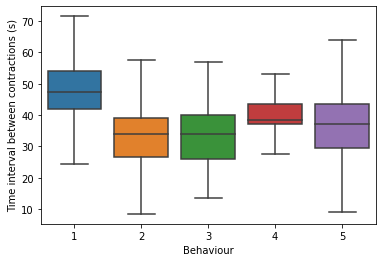

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x="behaviour", y="low_time",orient='v', data=final_data_corrected, showfliers=False)
plt.xlabel('Behaviour')
plt.ylabel('Time interval between contractions (s)')
plt.show()

In [ ]:
final_data_rest.describe()

# Confusion Matrix

[Explanation for scores](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

In [ ]:
results = confusion_matrix(final_data_corrected['rumination_video'], final_data_corrected['rumination_alg'])

print('Confusion Matrix Algoritm Rob with data Maurits:')
print(results) 
print('Accuracy Score : ', accuracy_score(final_data_corrected['rumination_video'], final_data_corrected['rumination_alg']))
print('Report : ')
print(classification_report(final_data_corrected['rumination_video'], final_data_corrected['rumination_alg']))

In [ ]:
results = confusion_matrix(final_data['rumination_video'], final_data['rumination_alg'])

print('Confusion Matrix:')
print(results) 
print('Accuracy Score : ', accuracy_score(final_data['rumination_video'], final_data['rumination_alg']))
print('Report : ')
print(classification_report(final_data['rumination_video'], final_data['rumination_alg']))

In [ ]:
results_corrected = confusion_matrix(final_data_corrected['rumination_video'], final_data_corrected['rumination_alg'])

print('Confusion Matrix Corrected Data without measuring errors :')
print(results) 
print('Accuracy Score : ', accuracy_score(final_data_corrected['rumination_video'], final_data_corrected['rumination_alg']))
print('Report : ')
print(classification_report(final_data_corrected['rumination_video'], final_data_corrected['rumination_alg']))

In [ ]:
results_selected = confusion_matrix(final_data_selected['rumination_video'], final_data_selected['rumination_alg'])

print('Confusion Matrix :')
print(results) 
print('Accuracy Score : ', accuracy_score(final_data_selected['rumination_video'], final_data_selected['rumination_alg']))
print('Report : ')
print(classification_report(final_data_selected['rumination_video'], final_data_selected['rumination_alg']))

# Cross tables

In [ ]:
pd.crosstab(df_concat_video.code_1_5, columns="count").apply(lambda r: r/len(df_concat_video), axis=1)

In [ ]:
pd.crosstab(df_concat_processed.rumination_alg,columns="count")

In [ ]:
pd.crosstab(df_concat_video.rumination_video, columns="count")

In [ ]:
pd.crosstab(final_data_selected.code_1_5, final_data_selected.rumination_alg)

# Descriptive statistics data

In [ ]:
from scipy.stats import iqr


In [ ]:
final_data_eat.count()

In [ ]:
final_data_rest.count()

In [ ]:
final_data_rum.count()

In [ ]:
final_data_sleep.count()

In [ ]:
final_data_drink.count()

In [ ]:
final_data_rest['low_time'].mean() 

In [ ]:
final_data_rest['low_time'].median() 

In [ ]:
final_data_rest['low_time'].std()

In [ ]:
iqr(final_data_rest['low_time'])

In [ ]:
final_data_eat['low_time'].mean() 

In [ ]:
final_data_eat['low_time'].median() 

In [ ]:
final_data_eat['low_time'].std()

In [ ]:
iqr(final_data_eat['low_time'])

In [ ]:
final_data_drink['low_time'].mean() 

In [ ]:
final_data_drink['low_time'].std() 

In [ ]:
final_data_drink['low_time'].median() 

In [ ]:
iqr(final_data_drink['low_time'])

In [ ]:
final_data_sleep['low_time'].mean() 

In [ ]:
final_data_sleep['low_time'].median() 

In [ ]:
iqr(final_data_sleep['low_time'])

In [ ]:
final_data_sleep['low_time'].std() 

In [ ]:
iqr(final_data_rum['low_time'])

In [ ]:
final_data_rum['low_time'].mean()

In [ ]:
final_data_rum['low_time'].std()

In [ ]:
final_data_rum['low_time'].median()

In [ ]:
final_data_rest['low_time'].median()   

In [ ]:
iqr(final_data_rest['low_time'])

In [ ]:
final_data_rest['low_time'].mean()  

In [ ]:
final_data_rest['low_time'].std()

In [ ]:
final_data_sleep['low_time'].median()

In [ ]:
final_data_sleep['low_time'].mean()


In [ ]:
final_data_sleep['low_time'].std()

In [ ]:
iqr(final_data_sleep['low_time'])

In [ ]:
final_data_drink['low_time'].mean()

In [ ]:
final_data_drink['low_time'].std()

In [ ]:
final_data_drink['low_time'].median()

In [ ]:
iqr(final_data_drink['low_time'])

In [ ]:
import matplotlib.pyplot as plt
final_data_eat['low_time'].plot.box( xticks=[]);
final_data_sleep['low_time'].plot.box( xticks=[]);
plt.xlabel('Eating');

plt.show(block=True);

In [ ]:
iqr(final_data_drink['low_time'])